In [6]:
import torch
import pytorch_lightning as pl
from models.pi_nets import CCP, CCP_relu, CCP_relu_poly
from models.neural_nets import FeedForwardNN, PolynomialNN, PolynomialNN_relu
from data.polynomials import PolynomialGenerator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
import torch.distributions as dist
from utils import model_utils
%load_ext autoreload
%autoreload 2

# Model Performance

In [7]:
checkpoint = r"tb_logs\2a3_times_6b2\CCP_relu\version_0\checkpoints\epoch=49-step=3200.ckpt"
model = CCP_relu.load_from_checkpoint(checkpoint)
polynomial = lambda a,b: 2*a**3*6*b**2

Lightning automatically upgraded your loaded checkpoint from v1.9.0 to v2.0.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file c:\Users\Bruger\Documents\Thesis-Code\tb_logs\2a3_times_6b2\CCP_relu\version_0\checkpoints\epoch=49-step=3200.ckpt`


In [8]:
model_utils.count_parameters(model)

1025

In [82]:
import yaml
import io
with io.open(r'tb_logs\two_variable_noise\CCP\5x2+6y2\normal(0,1)\hparams.yaml', "r") as f:
    data = yaml.safe_load(f)
data

{'bias': True,
 'data_dist': 'Normal(loc: 0.0, scale: 1.0)',
 'hidden_size': 64,
 'input_size': 2,
 'n_degree': 2,
 'noise': 'Normal(loc: 0.0, scale: 1.0)',
 'output_size': 1}

In [11]:
n_features = polynomial.__code__.co_argcount
#dataloader = PolynomialGenerator(polynomial, 100000, n_features, dist.normal.Normal(0,5))
#dataloader.setup("fit")
#train_dataloader = dataloader.train_dataloader()


In [20]:
y[0]

tensor(-24.5346)

In [17]:
x[0]

tensor([-1.0199, -1.3883])

In [19]:
(-1.0199)**3*(-1.3883)**2

-2.044746260784019

In [52]:
test = torch.vmap(polynomial)

In [53]:
x_test = x.permute(0,1)

In [56]:
test(x_test[0,:], x_test[0,:])

tensor([-13.2398, -61.8905])

In [26]:
x.permute(1,0).shape

torch.Size([2, 32])

In [32]:
polynomial(*torch.tensor([[1, 2, 3], [1,2,3]]))

tensor([  12,  384, 2916])

In [38]:
*x.permute(0,1)

SyntaxError: can't use starred expression here (1267907365.py, line 4)

In [28]:
polynomial(*x.clone().permute(1,0)).shape

torch.Size([32])

In [19]:
scales = range(90, 100)
means = range(0, 5)
plot_dict = {'mu': [],
             'sigma': [],
             'r2': []}
for mu in means:
    for sigma in scales:
        plot_dict['mu'].append(mu)
        plot_dict['sigma'].append(sigma)
        distribution = dist.normal.Normal(mu, sigma)
        x = distribution.sample((25000,n_features))
        y = polynomial(*x.clone().permute(1,0))
        with torch.no_grad():
            y_hat = model(x)
            plot_dict['r2'].append(r2_score(y, y_hat))
            
df = pd.DataFrame(plot_dict)
data = df.pivot(index="mu", columns="sigma", values="r2")

In [20]:
data

sigma,90,91,92,93,94,95,96,97,98,99
mu,,,,,,,,,,
0,0.895252,0.899789,0.889713,0.896449,0.890145,0.888073,0.899572,0.892204,0.885890,0.902485
1,0.890843,0.903883,0.888790,0.885230,0.897573,0.882052,0.890398,0.905205,0.897598,0.859865
2,0.881039,0.889944,0.886296,0.897580,0.886569,0.895351,0.872168,0.890316,0.899445,0.893754
3,0.898813,0.884452,0.876099,0.888344,0.898314,0.903576,0.897698,0.887526,0.907487,0.883034
4,0.885316,0.898354,0.884837,0.900744,0.882773,0.900480,0.882430,0.893235,0.882878,0.885646


c:\Users\Bruger\miniconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == "":
c:\Users\Bruger\miniconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


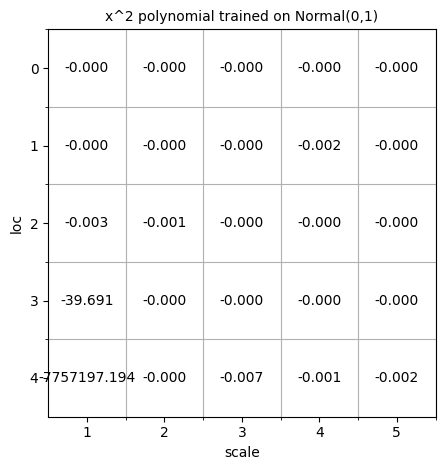

In [8]:
loc = 0
scale = 1
fig, ax = plt.subplots()
ax.set_title("x^2 polynomial trained on Normal(0,1)", fontsize=10)
ax.grid(True, which="minor")
ax.imshow(data, alpha=0)

ax.set_ylabel("loc")
ax.set_xlabel("scale")
ax.set_xticks(np.array(scales)-0.5, minor=True)
ax.set_yticks(np.array(means)-0.5, minor=True)
ax.set_yticklabels([''] + data.index.values.tolist())
ax.set_xticklabels([''] + data.columns.values.tolist())

for (i, j), z in np.ndenumerate(data):
    ax.text(j, i, '{:0.3f}'.format(z), ha="center", va="center")

#fig.suptitle("PolyNN R2 for shifting distributions");
fig.tight_layout()
#fig.savefig("imgs/PolyNN_x2_test.png", dpi=600, transparent=True)

R2: -0.0005516316404605703


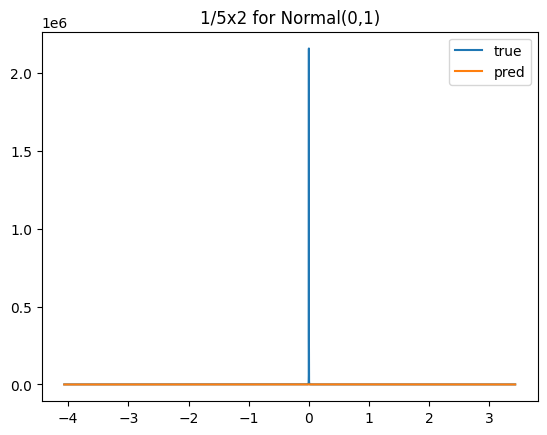

In [17]:
dist = Normal(0, 1)
x = dist.sample((10000,1))
y = x.clone().apply_(polynomial)

with torch.no_grad():
    y_hat = model(x)
    print("R2:", r2_score(y, y_hat))

indices = torch.argsort(x, dim=0).squeeze()
plt.plot(x[indices], y[indices], label="true")
plt.plot(x[indices], y_hat[indices], label="pred")
plt.legend()
plt.title("1/5x2 for Normal(0,1)");

R2: -152870.5153965726


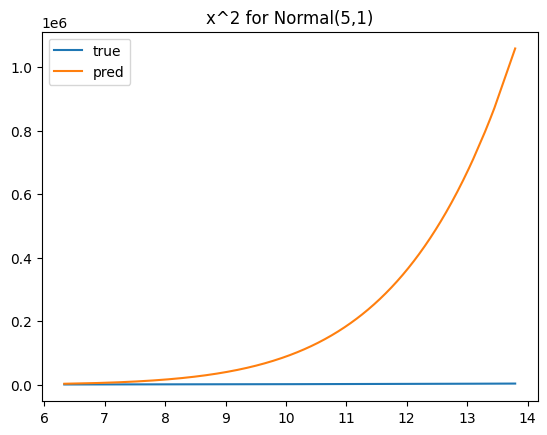

In [51]:
dist = Normal(10, 1)
x = dist.sample((10000,1))
y = x.clone().apply_(polynomial)

with torch.no_grad():
    y_hat = model(x)
    print("R2:", r2_score(y, y_hat))

indices = torch.argsort(x, dim=0).squeeze()
plt.plot(x[indices], y[indices], label="true")
plt.plot(x[indices], y_hat[indices], label="pred")
plt.legend()
plt.title("x^2 for Normal(5,1)");

In [ ]:
logger = pl.loggers.TensorBoardLogger("tb_logs", name="feedfoward_x2")
trainer = pl.Trainer(limit_train_batches=64,max_epochs=30, log_every_n_steps=25, logger=logger)
trainer.test(model, dataloaders=dataloader)